### Own probability calculator

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import sys
from scipy import stats
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
from sympy.tensor.array import derive_by_array
from numpy import identity, array, dot, matmul
from latex2sympy2 import latex2sympy
from sympy import *
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate, integrate

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef
from ExternalFunctions import nice_string_output, add_text_to_ax, UnbinnedLH

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [3]:
def calcPathLength(cz,r=6371.,h=15.,d=1.) :
    '''
    cz = cos(zenith) in radians, to be converted to path length in km
    r = Radius of Earth, in km
    h = Production height in atmosphere, in km
    d = Depth of detector, in km
    '''
    return -r*cz +  np.sqrt( (r*cz)**2 - r**2 + (r+h+d)**2 )

In [4]:
eBins = 200
#eList = np.linspace(1, 100, eBins)  # GeV
eList = np.logspace(0,2, eBins)
    
n_theta = 200
cos_theta = np.linspace(-1, 1, n_theta)
L = calcPathLength(cos_theta) # km

# parameters from //www.nu-fit.org/?q=node/238. We use the approximation DM31 = DM32
#DM21   = 7.60e-5   #eV
theta13 =  8.62/180 * np.pi #np.arcsin(np.sqrt(0.025))/np.pi*180.
theta12 = 33.45/180 * np.pi  #np.arcsin(np.sqrt(0.312))/np.pi*180. 

In [5]:
def prob_numu_numu(theta23, DM32):
        
    prob = 1 - 4*np.sin(theta23)**2 *np.cos(theta13)**2 *(1 - np.sin(theta23)**2 *np.cos(theta13)**2) \
    *np.sin(-1.27 * DM32 * L[np.newaxis,:].T /eList)**2
    
    return prob

In [6]:
def prob_numu_nue(theta23, DM32):
        
    prob = 4*np.sin(theta23)**2 *np.cos(theta13)**2 *np.sin(theta13)**2 *np.sin(-1.27 * DM32 * L[np.newaxis,:].T /eList)**2
    
    return prob

In [7]:
def prob_numu_nutau(theta23, DM32):
        
    prob = 4*np.sin(theta23)**2 *np.cos(theta13)**4 * np.cos(theta23)**2 *np.sin(-1.27 * DM32 * L[np.newaxis,:].T /eList)**2
    
    return prob

In [8]:
theta23_true = 42.1/180*np.pi 
DM32_true = 2.51e-3   #eV

from time import time
t = time()

prob_mu = prob_numu_numu(theta23_true, DM32_true);
print(f'{time()-t} s')

0.0029790401458740234 s


In [9]:
prob_e = prob_numu_nue(theta23_true, DM32_true)
prob_tau = prob_numu_nutau(theta23_true, DM32_true);

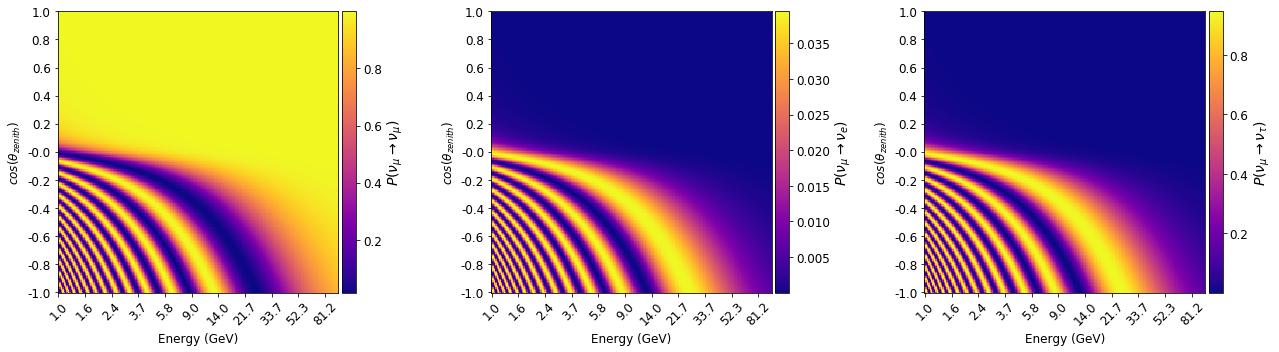

In [10]:
cos_theta = np.linspace(-1, 1, 200)

fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax.ravel()

im_mu = ax[0].imshow(prob_mu, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider_mu = make_axes_locatable(ax[0])
cax_mu = divider_mu.append_axes("right", size="5%", pad=0.05)
cbar_mu = plt.colorbar(im_mu, cax=cax_mu)
cbar_mu.set_label(r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$', fontsize=14)

im_e = ax[1].imshow(prob_e, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider_e = make_axes_locatable(ax[1])
cax_e = divider_e.append_axes("right", size="5%", pad=0.05)
cbar_e = plt.colorbar(im_e, cax=cax_e)
cbar_e.set_label(r'$P(\nu_{\mu} \rightarrow \nu_e)$', fontsize=14)

im_tau = ax[2].imshow(prob_tau, cmap='plasma', norm = None, origin = 'lower')  #[:,0:200]
divider_tau = make_axes_locatable(ax[2])
cax_tau = divider_tau.append_axes("right", size="5%", pad=0.05)
cbar_tau = plt.colorbar(im_tau, cax=cax_tau)
cbar_tau.set_label(r'$P(\nu_{\mu} \rightarrow \nu_{\tau})$', fontsize=14)

for n in range(3):
    ax[n].set_xlabel('Energy (GeV)')
    ax[n].set_ylabel(r'$cos(\theta_{zenith})$')
    ax[n].set_xticks(np.arange(0, 200, 19))
    ax[n].set_xticklabels([f'{np.round(eList[i],1)}' for i in np.arange(0, 200, 19)], rotation=45)
    ax[n].set_yticks(np.linspace(0, 200, 11))
    ax[n].set_yticklabels([f'{i}' for i in np.round(np.arange(-1,1.1,0.2),1)])

fig.tight_layout()
#fig.savefig('Oscprob_own_3nu');

In [11]:

# cos intervals for binning
cos_intervals = np.round(np.arange(1, -1, -0.1), 2)
cos_bins = np.digitize(cos_theta, cos_intervals, right=True)                                
    
# energy intervals
energy_min = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(eList, energy_min)
energy_binwidths = energy_max - energy_min
x_interp = np.linspace(energy_min[0], energy_max[-1], 10000)
energy_bins_spline = np.digitize(x_interp, energy_min)

x_interp_theta = np.linspace(-1, 1, 10000)
theta_bins = np.arange(1, -1, -0.1)
theta_bins_spline = np.digitize(x_interp_theta, theta_bins, right=True)
theta_binwidths = np.ones(20)*0.1
# Labels 

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min, energy_max[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

In [12]:
def bin_matrix(matrix, make_plot = False, savefig = None, binning=None):
    
    #Binning
    matrix_ybinned = np.zeros((len(cos_intervals) , len(matrix[0])))
    binned_matrix = np.zeros((20, 10))

    if binning == 'old':
     
        # averaging rows in same interval
        for i in range(1, len(cos_intervals)+1):
            rows = np.where(cos_bins == i)[0]
            averaged_row = np.mean(matrix[rows[0] : rows[-1]+1, : ], axis = 0)
            matrix_ybinned[ i-1 , : ] = averaged_row
            
        # averaging columns in same interval
        for i in range(1, len(energy_min)+1):
            columns = np.where(energy_bins == i)[0]
            averaged_column = np.mean(matrix_ybinned[ : , columns[0] : columns[-1]+1], axis = 1)
            binned_matrix[ : , i-1 ] = averaged_column

    else:
        for e in range(len(matrix[0])):
            y_interp_theta = interpolate.pchip_interpolate(cos_theta, matrix[:,e], x_interp_theta)
            avg = np.zeros(20)

            for i in range(1, 21):
                x_integrate = x_interp_theta[theta_bins_spline == i]
                y_integrate = y_interp_theta[theta_bins_spline == i]
                integral = np.trapz(y_integrate, x=x_integrate, dx=0.001, axis=- 1)
                avg[i-1] = integral / 0.1

            matrix_ybinned[:,e] = avg


        for theta in range(20):
            y_interp = interpolate.pchip_interpolate(eList, matrix_ybinned[theta], x_interp)
            avg = np.zeros(len(energy_min))

            for i in range(1, len(energy_min)+1):
                x_integrate = x_interp[energy_bins_spline == i]
                y_integrate = y_interp[energy_bins_spline == i]
                integral = np.trapz(y_integrate, x=x_integrate, dx=0.001, axis=- 1)
                avg[i-1] = integral / energy_binwidths[i-1]

            binned_matrix[theta] = avg
        
    if make_plot == True:
        fig, ax = plt.subplots(figsize=(10,7))

        im = ax.imshow(binned_matrix, cmap='plasma')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = plt.colorbar(im, cax=cax)
        ax.set_xlabel('Energy (GeV)')
        ax.set_ylabel(r'$cos(\theta_{zenith})$')
        ax.set_xticks(xticks)
        ax.set_xticklabels(energy_strings, rotation = 45)
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        cbar_label = r'$P(\nu_{\mu} \rightarrow \nu_{\mu})$'
        cbar.set_label(cbar_label)
        
        if savefig != None:
            fig.savefig(savefig)
        
    return binned_matrix

In [13]:
from time import time

0.36421656608581543 s


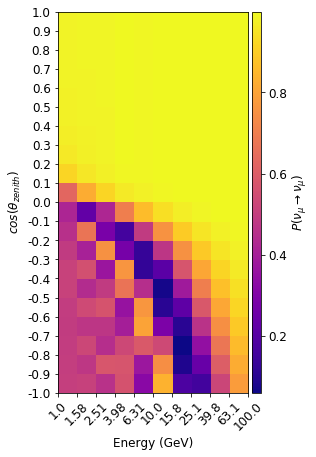

In [16]:
t = time()
osc_prob_spline = bin_matrix(prob_mu, make_plot=True, savefig='P_numu_numu_own')
print(time()-t, 's');

In [161]:
np.savetxt('osc_prob_spline', osc_prob_spline, delimiter=',')

0.0523679256439209 s


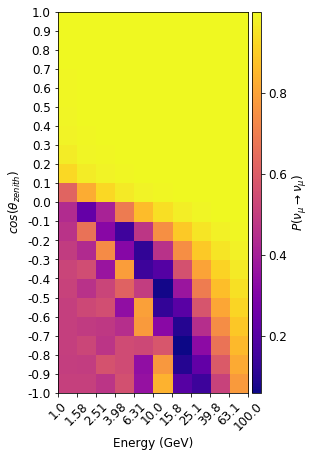

In [224]:
t = time()
binned_matrix = bin_matrix(prob, make_plot=True, binning='old')
print(time()-t, 's');

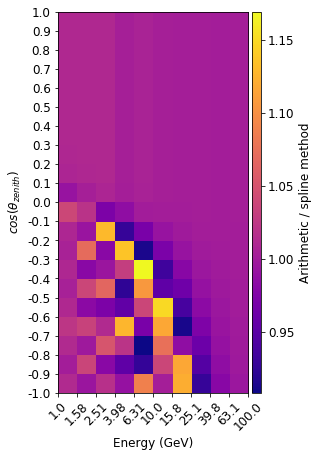

In [230]:
fig, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(binned_matrix/osc_prob_spline, cmap='plasma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(energy_strings, rotation = 45)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
cbar_label = r'Arithmetic / spline method'
cbar.set_label(cbar_label)

In [238]:
print(' #higher:', np.sum(np.array([binned_matrix/osc_prob_spline > 1])), '#lower:', np.sum(np.array([binned_matrix/osc_prob_spline < 1])))

 #higher: 148 #lower: 52
